In [165]:
import pandas as pd
import numpy as np

from pathlib import Path
from tqdm import tqdm
import pickle as pkl

from testbed.models.ngboost import NGBoostGaussian, NGBoostMixtureGaussian
from testbed.models.treeffuser import Treeffuser

from functools import partial

from jaxtyping import Float, Array
from typing import List, Callable

import seaborn as sns
import matplotlib.pyplot as plt

path = "../src/testbed/data/m5"

# load autoreload extension
%load_ext autoreload
%autoreload 2

In [21]:
# These are config variables

PROCESS_FROM_SCRATCH = False
USE_SUBSET = True
CONTEXT_LENGTH = 10

In [3]:

sell_prices_df = pd.read_csv(Path(path) / "sell_prices.csv")
sales_train_validation_df = pd.read_csv(Path(path) / "sales_train_validation.csv")
calendar_df = pd.read_csv(Path(path) / "calendar.csv")

print("columns of sell_prices_df", sell_prices_df.columns)
print("columns of sales_train_validation_df", sales_train_validation_df.columns)
print("columns of calendar_df", calendar_df.columns)


columns of sell_prices_df Index(['store_id', 'item_id', 'wm_yr_wk', 'sell_price'], dtype='object')
columns of sales_train_validation_df Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)
columns of calendar_df Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')


In [4]:
# add explicit columns for the day, month, year
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df["day"] = calendar_df["date"].dt.day
calendar_df["month"] = calendar_df["date"].dt.month
calendar_df["year"] = calendar_df["date"].dt.year

calendar_df["month"]

0       1
1       1
2       1
3       2
4       2
       ..
1964    6
1965    6
1966    6
1967    6
1968    6
Name: month, Length: 1969, dtype: int32

The strategy for processing the data is going to be the following. 1) We are going to have X and y where y is the next days sales for a given product. 3) X is made up of 10 previous prices, day of the week, + event types, cat_id, store_id, state_id

In [7]:
if PROCESS_FROM_SCRATCH:
    X_train = []
    y_train = []

    X_test = []
    y_test = []

    total_days = 1913
    train_days = int(total_days * 0.8)
    test_days = total_days - train_days
    context_length = CONTEXT_LENGTH

    # Precompute the required data
    calendar_df_dict = calendar_df.set_index("d").to_dict(orient="index")
    sell_prices_dict = sell_prices_df.groupby(["item_id", "store_id"])["sell_price"].first().to_dict()

    pbar = tqdm(total=len(sales_train_validation_df))
    for _, row in sales_train_validation_df.iterrows():
        item_id = row["item_id"]
        store_id = row["store_id"]

        pbar.update(1)
        for j in range(1, total_days - context_length):
            x = []

            # Add sales values for the previous context_length days
            x.extend(row[f"d_{j+k}"] for k in range(context_length))

            # Add additional features
            current_day = f"d_{j+context_length}"
            calendar_data = calendar_df_dict[current_day]
            x.extend([
                calendar_data["wday"],
                calendar_data["month"],
                store_id,
                calendar_data["event_name_1"],
                calendar_data["event_name_2"],
                sell_prices_dict[(item_id, store_id)],
                item_id
            ])

            if j < train_days:
                X_train.append(x)
                y_train.append(row[current_day])

            else:
                X_test.append(x)
                y_test.append(row[current_day])





In [8]:
if PROCESS_FROM_SCRATCH:
    # Save X_train, y_train, X_test, y_test
    import pickle as pkl

    with open("X_train.pkl", "wb") as f:
        pkl.dump(X_train, f)

    with open("y_train.pkl", "wb") as f:
        pkl.dump(y_train, f)

    with open("X_test.pkl", "wb") as f:
        pkl.dump(X_test, f)

    with open("y_test.pkl", "wb") as f:
        pkl.dump(y_test, f)



In [77]:
if PROCESS_FROM_SCRATCH:
    np.random.seed(42)
    len_subset = 100000

    train_idx_subset = np.random.choice(len(X_train), len_subset)
    test_idx_subset = np.random.choice(len(X_test), len_subset)

    X_train_subset = [X_train[i] for i in train_idx_subset]
    y_train_subset = [y_train[i] for i in train_idx_subset]

    X_test_subset = [X_test[i] for i in test_idx_subset]
    y_test_subset = [y_test[i] for i in test_idx_subset]

    print("len(X_train_subset)", len(X_train_subset))
    print("len(y_train_subset)", len(y_train_subset))

    with open("X_train_subset.pkl", "wb") as f:
        pkl.dump(X_train_subset, f)

    with open("y_train_subset.pkl", "wb") as f:
        pkl.dump(y_train_subset, f)

    with open("X_test_subset.pkl", "wb") as f:
        pkl.dump(X_test_subset, f)

    with open("y_test_subset.pkl", "wb") as f:
        pkl.dump(y_test_subset, f)







In [78]:
if not PROCESS_FROM_SCRATCH:

    if USE_SUBSET:
        with open("X_train_subset.pkl", "rb") as f:
            X_train = pkl.load(f)

        with open("y_train_subset.pkl", "rb") as f:
            y_train = pkl.load(f)

        with open("X_test_subset.pkl", "rb") as f:
            X_test = pkl.load(f)

        with open("y_test_subset.pkl", "rb") as f:
            y_test = pkl.load(f)

    else:
        with open("X_train.pkl", "rb") as f:
            X_train = pkl.load(f)

        with open("y_train.pkl", "rb") as f:
            y_train = pkl.load(f)

        with open("X_test.pkl", "rb") as f:
            X_test = pkl.load(f)

        with open("y_test.pkl", "rb") as f:
            y_test = pkl.load(f)

In [79]:
len(X_train), len(y_train), len(X_test), len(y_test)

(100000, 100000, 100000, 100000)

In [80]:
COL_NAMES = [
    f"day_{i}" for i in range(1, CONTEXT_LENGTH+1)
] + ["wday", "month", "store_id", "event_name_1", "event_name_2", "sell_price", "item_id"]

CAT_COLS = ["store_id", "event_name_1", "event_name_2", "item_id", "wday", "month"]
CAT_COLS_IDX = [COL_NAMES.index(col) for col in CAT_COLS]


In [88]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

X_train_df.columns = COL_NAMES
X_test_df.columns = COL_NAMES

In [89]:

X_train_df

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id
0,0,0,0,0,0,0,0,0,0,0,6,2,TX_1,NaN,NaN,1.48,HOUSEHOLD_2_496
1,2,3,3,2,1,9,2,2,1,0,4,8,CA_3,NaN,NaN,2.50,FOODS_3_386
2,2,1,0,0,0,0,0,0,1,0,3,3,WI_1,NaN,NaN,2.48,FOODS_2_237
3,2,1,5,0,0,0,4,1,3,3,2,7,TX_2,NaN,NaN,1.68,FOODS_3_015
4,0,0,0,0,0,0,0,0,0,0,2,3,TX_2,Purim End,NaN,5.98,FOODS_2_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,0,6,11,CA_2,NaN,NaN,3.97,HOUSEHOLD_2_386
99996,0,1,0,0,0,0,0,0,0,0,5,8,WI_3,NaN,NaN,5.84,HOUSEHOLD_2_205
99997,0,0,0,0,0,0,0,0,0,0,6,8,WI_1,NaN,NaN,2.48,HOUSEHOLD_2_230
99998,0,0,0,0,0,0,0,0,0,0,2,1,TX_1,NaN,NaN,2.97,HOUSEHOLD_1_043


In [90]:
# Encode the categorical columns as numbers
from sklearn.preprocessing import LabelEncoder
# Get only label of item_id
X_train_df["item_id"] = X_train_df["item_id"].apply(lambda x: x.split("_")[1])
X_test_df["item_id"] = X_test_df["item_id"].apply(lambda x: x.split("_")[1])


label_encoders = {}
for col in CAT_COLS:
    le = LabelEncoder()
    X_train_df[col] = le.fit_transform(X_train_df[col])
    X_test_df[col] = le.transform(X_test_df[col])
    label_encoders[col] = le

X_train_df


,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,wday,month,store_id,event_name_1,event_name_2,sell_price,item_id
0,0,0,0,0,0,0,0,0,0,0,5,1,4,30,4,1.48,1
1,2,3,3,2,1,9,2,2,1,0,3,7,2,30,4,2.50,2
2,2,1,0,0,0,0,0,0,1,0,2,2,7,30,4,2.48,1
3,2,1,5,0,0,0,4,1,3,3,1,6,5,30,4,1.68,2
4,0,0,0,0,0,0,0,0,0,0,1,2,5,23,4,5.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,0,5,10,1,30,4,3.97,1
99996,0,1,0,0,0,0,0,0,0,0,4,7,9,30,4,5.84,1
99997,0,0,0,0,0,0,0,0,0,0,5,7,7,30,4,2.48,1
99998,0,0,0,0,0,0,0,0,0,0,1,0,4,30,4,2.97,0


# PPC

In [153]:

def max_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    max_ppc = np.max(y_samples, axis=1)
    true_max = np.max(y_true)

    # plot the distribution of max_ppc
    ax = plt.subplot()
    #color = colors[number]
    #print("color", color)
    print("name", name)
    print("number", number)
    sns.histplot(max_ppc, ax=ax, color="red", label="max_ppc_{}".format(number) + name)
    ax.axvline(true_max, color="red", label="true_max_{}".format(number) + name)
    ax.legend()
    plt.show()



def quantile_ppc(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], quantile=0.5, number=0, name="") -> None:
    # rpeat y_true to match the shape of y_samples
    q = np.quantile(y_samples, quantile, axis=1)
    true_q = np.quantile(y_true, quantile)

    # plot the distribution of max_ppc
    ax = plt.subplot()
    sns.histplot(q, ax=ax, color="blue", label="{}th quantile".format(quantile))
    ax.axvline(true_q, color="red", label="true_{}th quantile".format(quantile))
    ax.legend()
    plt.show()

def zeros(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], number=0, name="") -> None:
    "Count the number of zeros in the samples"
    zeros = np.sum(y_samples < 0.1, axis=1)
    true_zeros = np.sum(y_true < 0.1)

    # plot the distribution of max_ppc
    ax = plt.subplot()
    sns.histplot(zeros, ax=ax, color="blue", label="zeros")
    ax.axvline(true_zeros, color="red", label="true_zeros")
    ax.legend()
    plt.show()

In [154]:
def plot_ppcs(y_true: Float[Array, "batch y_dim"], y_samples: Float[Array, "samples batch y_dim"], ppcs: List[Callable],
              number=0, name="") -> None:
    # plot the distribution of

    for ppc in ppcs:
        ppc(y_true, y_samples, number=number, name=name)

# Model Evaluation

In [155]:
# Simple helper function to train a model and plot ppcs

def train_and_plot_ppcs(model_cls, X_train, y_train, X_test, y_test, ppcs, number=0, name="") -> None:
    model = model_cls()
    model.fit(X_train, y_train)
    y_samples = model.sample(X_test, n_samples=100)

    plot_ppcs(y_test, y_samples, ppcs, number=number, name=name)
    return model


Now we can actually fit some of the models

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


name Treeffuser
number 0


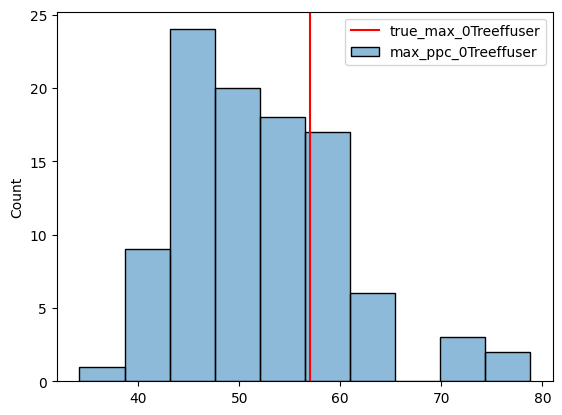

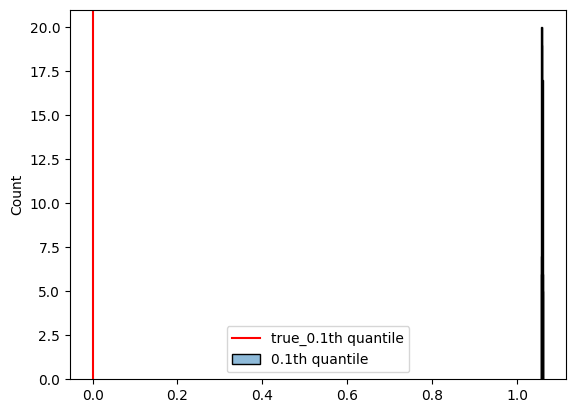

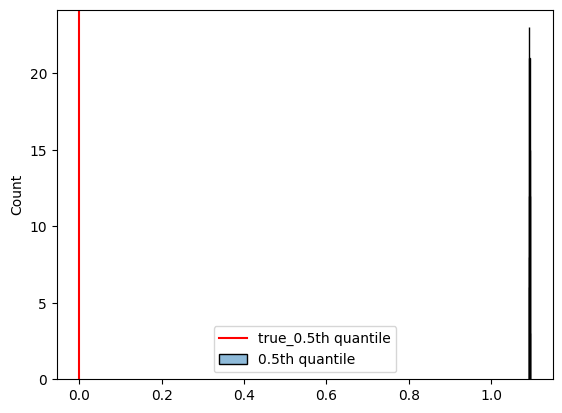

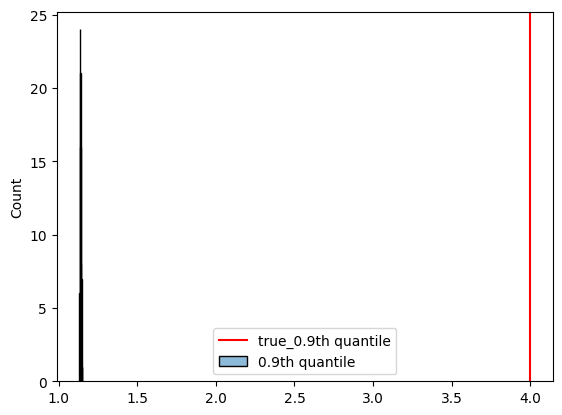

In [166]:
eval_values = 1000

X_train_np = X_train_df.values
X_test_np = X_test_df.values[:eval_values]

y_train_np = y_train_df.values
y_test_np = y_test_df.values[:eval_values]


model_classes = [Treeffuser]#, NGBoostGaussian]
ppcs = [max_ppc] + [partial(quantile_ppc, quantile=q) for q in [0.1, 0.5, 0.9]]

# check no nans
assert not np.isnan(X_train_np).any()
assert not np.isnan(y_train_np).any()
assert not np.isnan(X_test_np).any()
assert not np.isnan(y_test_np).any()


models = []
for i, model_cls in enumerate(model_classes):
    model = train_and_plot_ppcs(
        model_cls=model_cls,
        X_train=X_train_np,
        y_train=y_train_np,
        X_test=X_test_np,
        y_test=y_test_np,
        ppcs=ppcs,
        number=i,
        name=model_cls.__name__
    )
    models.append(model)


In [152]:
model = models[0]


pred = model.sample(X_test_np, n_samples=100)



100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


In [157]:
pred

array([[[1.12282446],
        [1.15360011],
        [1.10257856],
        ...,
        [1.07976481],
        [1.05663767],
        [1.05729348]],

       [[1.05178241],
        [1.03433635],
        [1.14378517],
        ...,
        [1.0537976 ],
        [1.10118373],
        [1.07956014]],

       [[1.07802363],
        [1.09538875],
        [1.09705811],
        ...,
        [1.07141979],
        [1.08277635],
        [1.10934663]],

       ...,

       [[1.09338067],
        [1.08267742],
        [1.11291171],
        ...,
        [1.01968047],
        [1.08306938],
        [1.08120721]],

       [[1.08048802],
        [1.100244  ],
        [1.08239208],
        ...,
        [1.06687349],
        [1.07620991],
        [1.09026767]],

       [[1.09220206],
        [1.09891821],
        [1.12196061],
        ...,
        [1.09226891],
        [1.06603116],
        [1.07208162]]])

In [159]:
pred[0]

array([[ 1.12282446],
       [ 1.15360011],
       [ 1.10257856],
       [ 1.0552948 ],
       [ 1.08555708],
       [ 1.0781215 ],
       [ 1.07937068],
       [ 1.10551585],
       [ 5.01628715],
       [ 1.06524915],
       [ 1.05606373],
       [ 1.0783194 ],
       [12.75505992],
       [ 1.07209405],
       [ 1.11657821],
       [ 1.08274844],
       [ 1.07201642],
       [ 1.07372344],
       [ 1.13298552],
       [ 1.08883362],
       [ 1.0924462 ],
       [ 1.07638288],
       [ 1.09397354],
       [ 1.10115166],
       [ 1.07753435],
       [ 1.05069749],
       [ 1.09920745],
       [ 1.10619573],
       [ 1.10038105],
       [ 1.07906581],
       [ 1.08124542],
       [ 1.11084234],
       [ 1.09473671],
       [ 1.05170174],
       [ 1.07501613],
       [ 1.08351289],
       [ 1.11598939],
       [ 1.07550519],
       [ 1.10482012],
       [ 1.11318601],
       [ 1.05519954],
       [ 4.92863924],
       [ 1.06657876],
       [ 1.11627169],
       [ 1.08321231],
       [ 1

In [160]:
y_test_np[0]

array([0])

In [161]:
y_test

[0,
 0,
 1,
 4,
 0,
 0,
 3,
 2,
 1,
 0,
 4,
 1,
 11,
 1,
 4,
 1,
 3,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 5,
 1,
 4,
 0,
 0,
 0,
 15,
 2,
 1,
 0,
 1,
 6,
 2,
 1,
 0,
 3,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 5,
 2,
 0,
 0,
 0,
 3,
 1,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 4,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 4,
 0,
 11,
 0,
 2,
 0,
 0,
 4,
 0,
 1,
 0,
 5,
 0,
 0,
 57,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 3,
 2,
 0,
 0,
 2,
 0,
 1,
 3,
 0,
 0,
 0,
 1,
 4,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 13,
 1,
 1,
 3,
 0,
 0,
 3,
 0,
 9,
 42,
 0,
 1,
 2,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 19,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 14,
 1,
 0,
 0,
 1,
 1,
 0,
 5,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 3,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 14,
 5,
 0,
 2,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 5,
 0,
 2,
 0,
 0,
 3,
 1,
 17,
 1

In [162]:
X_test_np[0]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  2.  ,  0.  ,  9.  , 30.  ,  4.  ,  2.87,  1.  ])